# Circle Minus Square - A Quick Intro to Solid Constructive Geometry
#### Ann Arbor Scientific and Technical Computing, September 24th 2020
#### Presented by David Perner
<img src="img/Csg_tree.png" style="height:50%; width:50%"></img>

In [1]:
using LinearAlgebra
using Plots
using StaticArrays
using ForwardDiff
using GR: meshgrid

First, let's define some basic surface types we can use to build up shapes. What we're doing is primarily defining a distance function, or how far from the shape's *surface* we are. The reason this is important is that is allows us to distinguish between the inside and outside of surfaces easily. The inside will have negative distance values whereas the outside's will be positive. This will also later allow us to find the surface itself by zero searching.

What's also important is how functions are passed around by the code. This allows us to take these distance field definitions and compose them, easily, into more and more complex shapes.

In [2]:
abstract type Surface end

struct Plane <: Surface
    point
    normal
    distance_field::Function
    normal_field::Function
    function Plane(p, n)
        dist = x->dot(n,x) - dot(n, p)
        norm = x->n
        new(p, n, dist, norm)
    end
end

struct Sphere <: Surface
    center
    radius::Float64
    distance_field::Function
    normal_field::Function
    function Sphere(c, r::Float64)
        dist = x->sqrt((x-c)⋅(x-c))-r
        norm = x->ForwardDiff.gradient(dist,x)
        new(c, r, dist, norm)
    end
end

struct ConstructedSurface <: Surface
    distance_field::Function
    normal_field::Function
    function ConstructedSurface(distance_field, normal_field)
        new(distance_field, normal_field)
    end
    function ConstructedSurface(distance_field)
        new(distance_field, x->ForwardDiff.gradient(distance_field,x))
    end
end

Plus some convenience functions for calcuating the distance from a surface and the value of the normal field at that point

In [3]:
function distance(surf, x)
   surf.distance_field(x) 
end

function normal(surf, x)
   surf.normal_field(x) 
end

normal (generic function with 1 method)

So now that we have the basic definitions down, let's take a look at what we've created. The unit circle is just a circle (or, in this case, a 2D sphere) with radius one centered at the origin, but we should be able to see a circular distance field with the normals pointing out from the origin.

In [4]:
unit_circle = Sphere(SVector(0.0,0.0), 1.0);

In [5]:
axis_range = range(-1,1,length=101);
quiver_range = range(-1,1,length=21)
X, Y = meshgrid(quiver_range,quiver_range);

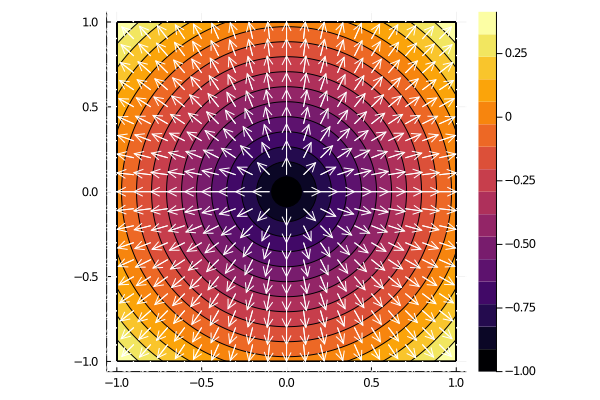

In [6]:
contour(
    axis_range,
    axis_range,
    (x,y)->distance(unit_circle, SVector(x,y)),
    aspect_ratio=1,
    fill = true
)
u=Vector{Float64}(undef, length(X))
v=Vector{Float64}(undef, length(X))
x_axis = Vector{Float64}(undef, length(X))
y_axis = Vector{Float64}(undef, length(X))
for ind in 1:length(X)
    grad_pnt = normal(unit_circle,SVector(X[ind],Y[ind]))
    u[ind]= grad_pnt[1]/10
    v[ind]= grad_pnt[2]/10
    x_axis[ind]=X[ind]
    y_axis[ind]=Y[ind]
end
quiver!(x_axis,y_axis,quiver=(u,v), xlim=[-1,1], ylim=[-1,1], color="white")

With the shape definitions working (or so it seems) let's define some additional operators. 
- Union, or all the points that fall in either shape
- Intersect, or all the points that fall in both shapes
- Subtraction, or all the points that shape A shares with shape B removed from shape A.

In addition, there is also a "complement" function, which reverses the sign of the distance field, which also makes what was the outside of the shape the inside and vice versa. 

It's also worth pointing out that subtraction is really the intersection of shape A with the complement of shape B. 

But how do we use distance fields to figure this out? Turns out that
- Union: The distance field of the new shape is the min of shapes A and B.
- Intersect: The distance field of the new shape is the max of shapes A and B
- Complement: Flip the distance field

This, plus some logic for the normals, is shown below

In [7]:
import Base: union, intersect, -

function union(x::T, y::S) where {T<:Surface, S<:Surface}
    x_dist_fun = (c)->distance(x,c)
    y_dist_fun = (c)->distance(y,c)
    dist_fun = (c)->min(x_dist_fun(c),y_dist_fun(c))
    x_norm_func = (x)->ForwardDiff.gradient(x_dist_fun,x)
    y_norm_func = (y)->ForwardDiff.gradient(y_dist_fun,y)
    norm_fun = (c)->
        if x_dist_fun(c) == y_dist_fun(c)
            if (x_norm_func(c)==y_norm_func(c)) #protects against self-union
                x_norm_func(c)
            else
                zeros(size(c))*NaN #the proper gradient here is undefined
            end
        elseif x_dist_fun(c) > y_dist_fun(c)
            y_norm_func(c)
        else
            x_norm_func(c)
        end
    return ConstructedSurface(dist_fun, norm_fun)
end

function intersect(x::T, y::S) where {T<:Surface, S<:Surface}
    x_dist_fun = (c)->distance(x,c)
    y_dist_fun = (c)->distance(y,c)
    dist_fun = (c)->max(x_dist_fun(c),y_dist_fun(c))
    x_norm_func = (x)->ForwardDiff.gradient(x_dist_fun,x)
    y_norm_func = (y)->ForwardDiff.gradient(y_dist_fun,y)
    norm_fun = (c)->
    if x_dist_fun(c) == y_dist_fun(c)
        if (x_norm_func(c)==y_norm_func(c)) #protects against self-union
            x_norm_func(c)
        else
            zeros(size(c))*NaN #the proper gradient here is undefined
        end
    elseif x_dist_fun(c) < y_dist_fun(c)
        y_norm_func(c)
    else
        x_norm_func(c)
    end
    return ConstructedSurface(dist_fun, norm_fun)
end

function -(x::T, y::S) where {T<:Surface, S<:Surface}
    intersect(x,complement(y))
end

function complement(x::T) where {T<:Surface}
    return ConstructedSurface((c)->-distance(x,c), (c)->-normal(x,c))
end

complement (generic function with 1 method)

So let's try this out, and make to circles that are offset from one another and perform these different operations on them

In [8]:
left_circle = Sphere(SVector(-0.25, 0.0), 0.65)
right_circle = Sphere(SVector(0.25, 0.0), 0.65);

In [9]:
half_moon = left_circle - right_circle;

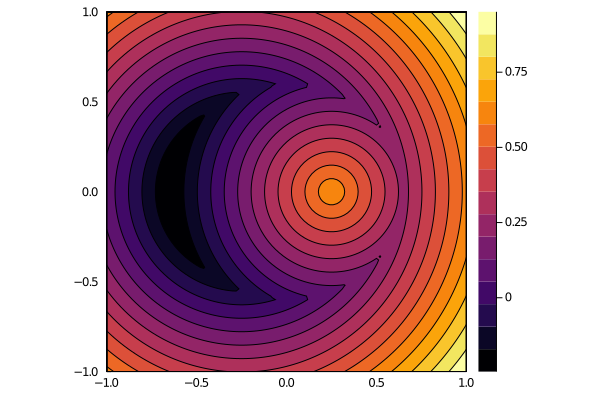

In [10]:
contour(
    axis_range,
    axis_range,
    (x,y)->distance(half_moon, SVector(x,y)),
    aspect_ratio=1,
    fill = true,
    xlim = [-1,1],
    ylim = [-1,1]
)

In [11]:
double_circ = left_circle ∪ right_circle; 

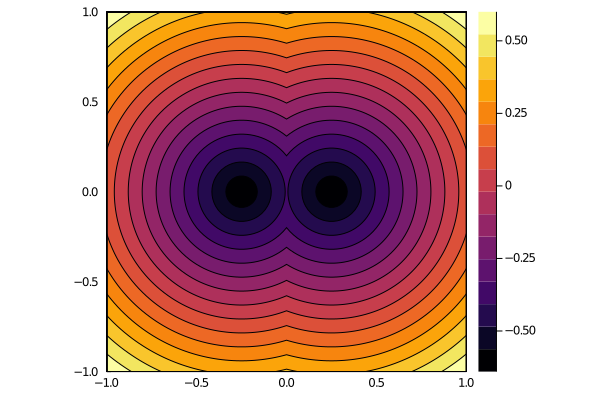

In [12]:
contour(
    axis_range,
    axis_range,
    (x,y)->distance(double_circ, SVector(x,y)),
    aspect_ratio=1,
    fill = true,
    xlim = [-1,1],
    ylim = [-1,1]
)

In [13]:
sliver = left_circle ∩ right_circle;

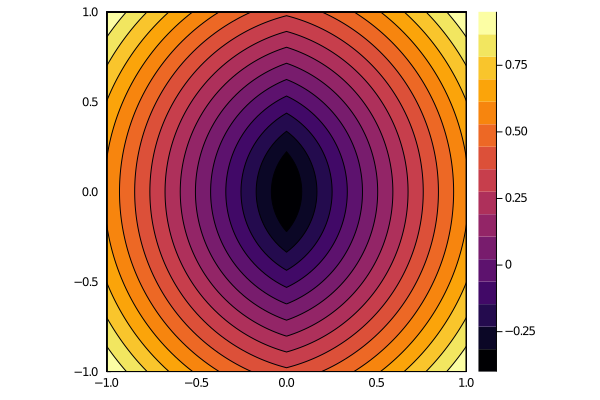

In [14]:
contour(
    axis_range,
    axis_range,
    (x,y)->distance(sliver, SVector(x,y)),
    aspect_ratio=1,
    fill = true,
    xlim = [-1,1],
    ylim = [-1,1]
)

It's also worth pointing out that the `ConstructedSurface` type can serve two jobs. The first is a place to store shapes formed as a combination of base shapes, but we can also use it to define brand new shapes. For example, let's define an ellipse. Thankfully, `ForwardDiff` a Julia package, can do auto-differentiation on Julia functions, and so we can get the normal field without having to derive/explicitly define it.

In [15]:
ellipse_def(c,a,r)=sqrt(dot(c./a,c./a))-r
ellipse=ConstructedSurface(c->ellipse_def(c,SVector(1.0,0.75),0.5));

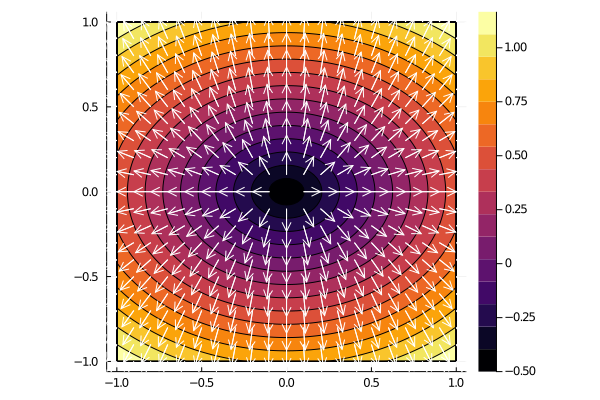

In [16]:
contour(
    axis_range,
    axis_range,
    (x,y)->distance(ellipse, SVector(x,y)),
    aspect_ratio=1,
    fill = true
)
u=Vector{Float64}(undef, length(X))
v=Vector{Float64}(undef, length(X))
x_axis = Vector{Float64}(undef, length(X))
y_axis = Vector{Float64}(undef, length(X))
for ind in 1:length(X)
    grad_pnt = normal(ellipse,SVector(X[ind],Y[ind]))
    u[ind]= grad_pnt[1]/10
    v[ind]= grad_pnt[2]/10
    x_axis[ind]=X[ind]
    y_axis[ind]=Y[ind]
end
quiver!(x_axis,y_axis,quiver=(u,v), xlim=[-1,1], ylim=[-1,1], color="white")

So let's make something a little more complex. Below we define two squares (one parallel to the axes and another rotated 90 degrees into a diamond) and remove a circle chunk of it on the top right. We'll call it an eclipse.

In [17]:
left_side = Plane(SVector(-0.5,0), SVector(-1,0))
right_side = Plane(SVector(0.5,0), SVector(1,0))
top_side = Plane(SVector(0,0.5), SVector(0,1))
bottom_side = Plane(SVector(0,-0.5), SVector(0,-1))

square = left_side ∩ right_side ∩ top_side ∩ bottom_side;

In [18]:
top_right_side    = Plane(SVector(0.5*sqrt(2),0.0), normalize(SVector(1,1)))
top_left_side     = Plane(SVector(0.0,0.5*sqrt(2)), normalize(SVector(-1,1)))
bottom_right_side = Plane(SVector(0.5*sqrt(2),0.0), normalize(SVector(1,-1)))
bottom_left_side  = Plane(SVector(0.0,-0.5*sqrt(2)), normalize(SVector(-1,-1)))

diamond = top_right_side ∩ top_left_side ∩ bottom_right_side ∩ bottom_left_side;

In [19]:
high_circle = Sphere(SVector(0.25, 0.25), 0.65);

In [20]:
eclipse = (square ∪ diamond) - high_circle;

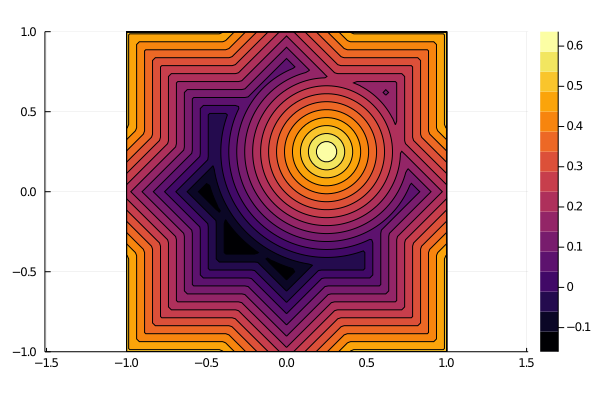

In [21]:
contour(
    axis_range,
    axis_range,
    (x,y)->distance(eclipse, SVector(x,y)),
    aspect_ratio=1,
    fill = true
)

While we can sort of trace out the shape using the color gradient, it would be a lot better if we could pick out some points to actually use to render the shape. One approach to do this is Dual Contouring, but that's perhaps a topic for another month. Still, a basic implementation of it follows below.

In [22]:
include("src/DualContourFields.jl")

DualContourField

In [23]:
dcf = DualContourField(eclipse,
    SVector(-1., -1), SVector(2., 2),
    1e-1, 1e-4
);

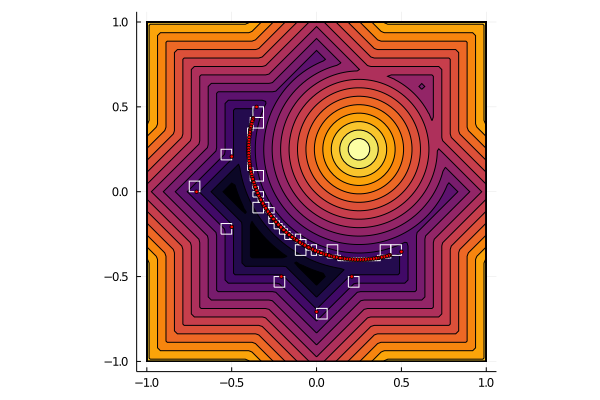

In [24]:
x = range(-1, 1,length=101)
y = range(-1, 1,length=101)
plt = Plots.contour(x, y, (x, y) -> distance(eclipse,SVector(x,y)), fill=true, 
    legend=nothing, aspect_ratio=:equal)
qef_min = []
ps = []
ns = []
nan_count = 0
nan_centers=[]
for leaf in allleaves(dcf.root)
    if !isempty(leaf.data.residual) && isfinite(leaf.data.residual)
        v = hcat(collect(vertices(leaf.boundary))...)
        Plots.plot!(plt, v[1,[1,2,4,3,1]], v[2,[1,2,4,3,1]], color=:white)
        push!(qef_min,leaf.data.qef_min)
        push!(ps,leaf.data.p...)
        push!(ns, leaf.data.n...)
    end
    if !isempty(leaf.data.residual) && !isfinite(leaf.data.residual)
    end
end

all_qef_min = hcat(qef_min...)
Plots.scatter!(plt,all_qef_min[1,:],all_qef_min[2,:],color=:red,markersize=2, xlim=[-1,1], ylim=[-1,1])

all_ps = hcat(ps...)
all_ns = hcat(ns...)
plt

The curved part of the shape is well sampled, but there are some numerical issues around corners that line up with breaks in how the code partitions the space. But for the most part we can see it samples areas with detail more heavily than areas that are mostly collections of straight lines.

## Conclusions
CSG is a powerful tool for representing shapes and operating on them to make complex geometries. However, it has several limits
- Is poorly suited to more "organic" shapes. Imagine how many operations it would take to make a hand.
- Lacks obvious support for swept or extruded shapes

I would expect (although don't know for sure that) the methods for surface modeling for these other scenarios have their own mathematical underpinnings, so if distance and normal fields can be constructed in ways that are better suited to these others sorts of work, the same tools presented here could operate on them as well. 